In [1]:
import math
import os
import re
import sys
sys.path.insert(0,'..')
from citylearn.utilities import read_json
from doe_xstock.database import SQLiteDatabase
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.utilities import DataHandler, FileHandler

# Set variables and make directories
---

In [2]:
DATABASE_FILEPATH = FileHandler.get_settings()['database_filepath']
DATABASE = SQLiteDatabase(DATABASE_FILEPATH)
os.makedirs(FileHandler.METADATA_DIRECTORY, exist_ok=True)
os.makedirs(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, exist_ok=True)

# Metadata tables
---

## Clustered buildings

In [3]:
building_ids = FileHandler.get_settings()['building_selection']['bldg_ids']
setpoint_ids = FileHandler.get_settings()['building_selection']['setpoint_ids']
ids_str = ','.join([f"({b}, '{'Tolerant' if '0' in s else 'Average'}')" for b, s in zip(building_ids, setpoint_ids)])
query = f"""
WITH b (bldg_id, setpoint_id) AS (
    VALUES {ids_str}
)

SELECT
    b.label + 1 AS "Cluster",
    b.bldg_id,
    b.setpoint_id,
    ROW_NUMBER() OVER() AS "ID",
    b.in_orientation AS "Orientation",
    b.in_vintage AS "Year-built",
    b.in_occupants AS "Occupants",
    b.in_infiltration AS "Infiltration",
    b.in_insulation_ceiling AS "Ceiling",
    b.in_insulation_slab AS "Slab",
    b.in_insulation_wall AS "Wall",
    b.eui AS "EUI (kWh/m2)",
    b.wwr AS "WWR"
FROM (
    SELECT
        b.bldg_id,
        b.setpoint_id,
        r.label,
        in_orientation,
        in_vintage,
        in_occupants,
        in_infiltration,
        in_insulation_ceiling,
        in_insulation_slab,
        in_insulation_wall,
        ROUND(out_site_energy_total_energy_consumption_intensity/0.092903, 0) AS eui,
        ROUND(in_window_area_ft_2 / in_wall_area_above_grade_exterior_ft_2, 2) AS wwr
    FROM b
    LEFT JOIN metadata m ON m.bldg_id = b.bldg_id
    LEFT JOIN metadata_clustering_label r ON r.metadata_id = m.id
    INNER JOIN optimal_metadata_clustering o ON o.clustering_id = r.clustering_id
    ORDER BY r.label, b.bldg_id
) b
;
"""
metadata = DATABASE.query_table(query)
metadata.insert(
    loc=3, 
    column='Geometry', 
    value='{\includegraphics[height=0.45in]{figures/building_geometry/' + metadata['bldg_id'].astype(str) + '}}'
)
display(metadata)

with pd.option_context("max_colwidth", 1000):
    filepath = os.path.join(FileHandler.METADATA_DIRECTORY, 'building_cluster_metadata.tex')
    tex = metadata.to_latex( escape=False, index=False)
    tex = re.sub(r'[ \t\f\v]+', ' ', tex)

    with open(filepath, 'w') as f:
        f.write(tex)

    metadata.to_csv(filepath.replace('.tex', '.csv'), index=False)

,Cluster,bldg_id,setpoint_id,Geometry,ID,Orientation,Year-built,Occupants,Infiltration,Ceiling,Slab,Wall,EUI (kWh/m2),WWR
0,1,199613,Tolerant,{\includegraphics[height=0.45in]{figures/build...,1,West,2000s,2,6 ACH50,R-30,None,"Wood Stud, R-19",122.0,0.11
1,1,247942,Tolerant,{\includegraphics[height=0.45in]{figures/build...,2,Northeast,2000s,3,4 ACH50,R-30,None,"Wood Stud, R-11",59.0,0.05
2,1,411001,Average,{\includegraphics[height=0.45in]{figures/build...,3,Northeast,1990s,1,10 ACH50,R-30,None,"Wood Stud, R-15",289.0,0.05
3,1,450491,Tolerant,{\includegraphics[height=0.45in]{figures/build...,4,Southwest,2010s,3,8 ACH50,None,None,"Wood Stud, R-19",235.0,0.13
4,1,508889,Average,{\includegraphics[height=0.45in]{figures/build...,5,Southwest,1980s,2,15 ACH50,R-30,None,"Wood Stud, R-19",359.0,0.07
5,1,525859,Tolerant,{\includegraphics[height=0.45in]{figures/build...,6,North,1980s,3,10 ACH50,R-19,None,"Wood Stud, R-19",348.0,0.26
6,2,20199,Tolerant,{\includegraphics[height=0.45in]{figures/build...,7,South,1970s,4,15 ACH50,R-30,None,"Wood Stud, R-7",226.0,0.06
7,2,75252,Average,{\includegraphics[height=0.45in]{figures/build...,8,South,1970s,4,10 ACH50,R-49,None,"Wood Stud, R-7",284.0,0.06
8,2,79194,Average,{\includegraphics[height=0.45in]{figures/build...,9,South,1970s,2,15 ACH50,R-13,None,"Wood Stud, R-7",278.0,0.24
9,2,376570,Average,{\includegraphics[height=0.45in]{figures/build...,10,South,1980s,2,15 ACH50,R-30,None,"Wood Stud, R-11",329.0,0.08


## Environment buildings

In [8]:
schema = read_json(os.path.join(FileHandler.SCHEMA_DIRECTORY, 'schema.json'))
data = [{
    'Bldg. ID': metadata[metadata['bldg_id']==int(k)].iloc[0]['ID'],
    'Heat pump (kW)': v['heating_device']['attributes']['nominal_power'],
    'Heat pump, ' + r'$\eta$': v['heating_device']['attributes']['efficiency'],
    'Electric heater (kW)': v['dhw_device']['attributes']['nominal_power'],
    'Electric heater, ' + r'$\eta$': v['dhw_device']['attributes']['efficiency']
} for k, v in schema['buildings'].items()]
data = pd.DataFrame(data).sort_values('Bldg. ID')
data.iloc[:, 1:] = data.iloc[:, 1:].round(2)

with pd.option_context("max_colwidth", 1000, 'display.max_columns', None):
    data = data.set_index('Bldg. ID').T.reset_index()
    display(data)
    filepath = os.path.join(FileHandler.METADATA_DIRECTORY, 'building_metadata.tex')
    tex = data.to_latex( escape=False, index=False)
    tex = re.sub(r'[ \t\f\v]+', ' ', tex)

    with open(filepath, 'w') as f:
        f.write(tex)

Bldg. ID,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,Heat pump (kW),23.23,14.50,18.67,40.41,46.77,12.23,46.88,41.02,43.85,36.57,15.28,30.38,44.90,38.68,37.44,29.69,27.33,22.19,28.94,17.53
1,"Heat pump, $\eta$",0.23,0.21,0.23,0.26,0.28,0.29,0.22,0.23,0.23,0.20,0.20,0.24,0.23,0.22,0.25,0.20,0.24,0.29,0.25,0.24
2,Electric heater (kW),21.34,8.28,6.46,9.73,19.32,24.20,15.08,19.08,18.13,17.52,22.73,15.97,17.80,37.04,35.13,7.60,10.42,20.24,6.49,19.70
3,"Electric heater, $\eta$",0.88,0.90,0.92,0.87,0.92,0.91,0.90,0.89,0.88,0.87,0.90,0.87,0.91,0.87,0.90,0.85,0.94,0.89,0.86,0.93


# Figures
---

## Average daily load profile

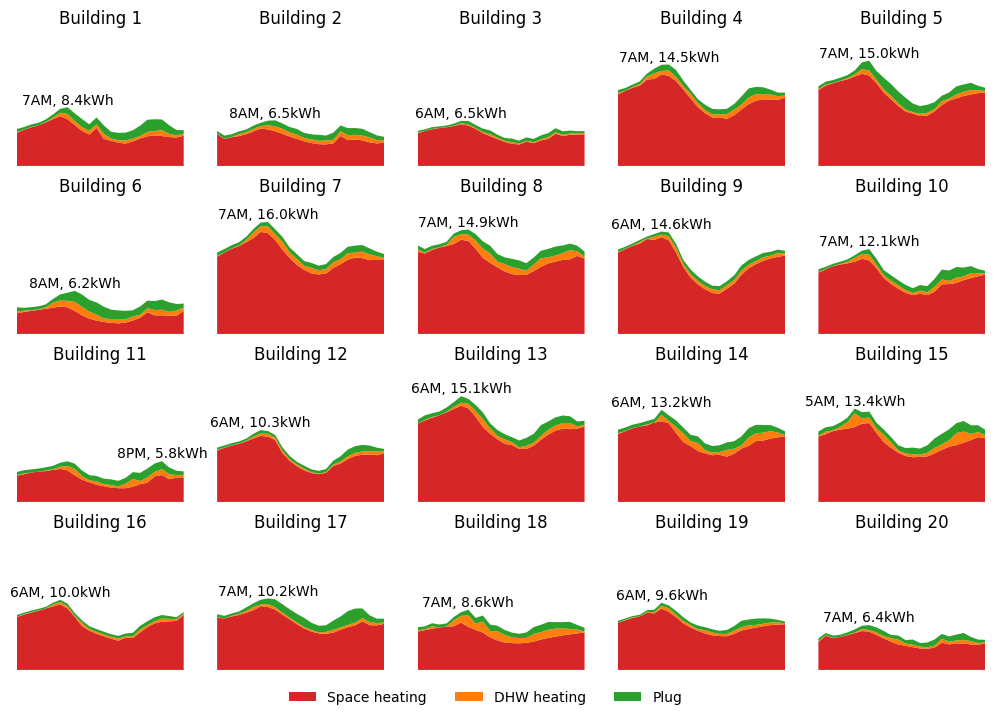

In [9]:
columns = ['heating_electricity_consumption', 'dhw_electricity_consumption', 'non_shiftable_load_electricity_consumption']
labels = ['Space heating', 'DHW heating', 'Plug']
colors = ['tab:red', 'tab:orange', 'tab:green']
data = DataHandler.get_concat_data('lod_1', 'time_series')
data['day_ix'] = (data['time_step']/24).astype(int)
data['hour'] = data['time_step'] - data['day_ix']*24
data = data.groupby(['bldg_name', 'hour'])[columns].mean().reset_index()
data['bldg_index'] = data['bldg_name'].map(lambda x: metadata[metadata['bldg_id']==int(x)].iloc[0]['ID'])
building_count = len(data['bldg_index'].unique())
column_count_limit = 5
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
fig, ax = plt.subplots(row_count, column_count, figsize=(2.5*column_count, 2.0*row_count), sharey=True, gridspec_kw={'hspace': 0.5})

for i, (ax, (b, bdata)) in enumerate(zip(fig.axes, data.groupby(['bldg_index']))):
    x = bdata['hour'].tolist()
    y = bdata[columns].values.T
    ax.stackplot(x, y, colors=colors, labels=labels)
    peak_hour = bdata.reset_index(drop=True)[columns].sum(axis=1).idxmax()
    peak = bdata[columns].sum(axis=1).max()

    if peak_hour == 0:
        peak_hour_str = f'12AM'

    elif peak_hour < 12:
        peak_hour_str = f'{peak_hour}AM'

    elif peak_hour == 12:
        peak_hour_str = '12PM'

    else:
        peak_hour_str = f'{peak_hour - 12}PM'

    ax.text(peak_hour, peak + 0.5, f'{peak_hour_str}, {round(peak, 1)}kWh', ha='center')
    ax.set_title(f'Building {b}', y=1.2)
    ax.margins(0)
    ax.axis(False)
    
    
    if i == 0:
        ax.legend(
            bbox_to_anchor=(0.5,0.1),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=len(columns)
        )
    
    else:
        pass
    
plt.savefig(os.path.join(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, f'average_daily_load_profile.pdf'), bbox_inches='tight', transparent=False)
plt.show()

In [10]:
plot_data = data.copy()
plot_data = plot_data.groupby('bldg_index')[columns].sum()
plot_data = plot_data.melt(ignore_index=False).reset_index()
plot_data['total'] = plot_data.groupby(['bldg_index'])[['value']].transform('sum')
plot_data['percentage'] = plot_data['value']*100.0/plot_data['total']
plot_data.groupby(['variable'])[['percentage']].describe()

percentage                       \
                                                count       mean       std   
variable                                                                     
dhw_electricity_consumption                      20.0   5.915031  3.063995   
heating_electricity_consumption                  20.0  84.327586  7.419268   
non_shiftable_load_electricity_consumption       20.0   9.757383  4.789787   

                                                                             \
                                                  min        25%        50%   
variable                                                                      
dhw_electricity_consumption                  2.867944   3.595718   4.983940   
heating_electricity_consumption             61.774321  81.504289  86.896461   
non_shiftable_load_electricity_consumption   4.684136   6.684620   8.211988   

                                                                  
                                                  75%        max  
variable                                                          
dhw_electricity_consumption                  6.660682  13.831373  
heating_electricity_consumption             89.166993  91.769691  
non_shiftable_load_electricity_consumption  11.655155  24.394307

## EnergyPlus simulation results

In [13]:
query = """
WITH u AS (
    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        'weighted_variable' AS label,
        r.Value
    FROM weighted_variable r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE d.Name IN ('Zone Air Temperature')

    UNION ALL
    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        'setpoint' AS label,
        r.Value
    FROM ReportData r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    LEFT JOIN Zones z ON z.ZoneName = d.KeyValue
    WHERE 
        d.Name IN ('Zone Thermostat Cooling Setpoint Temperature')

    UNION ALL

    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        CASE WHEN r.Value > 0 THEN 'equipment_heating_load' ELSE 'equipment_cooling_load' END AS label,
        ABS(r.Value) AS value
    FROM ReportData r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE 
        d.Name = 'Other Equipment Convective Heating Rate' AND
        (d.KeyValue LIKE '%HEATING_LOAD' OR d.KeyValue LIKE '%COOLING_LOAD')

    UNION ALL

    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        'ideal_cooling_load' AS label,
        ABS(r.Value) AS value
    FROM ReportData r
    INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE d.Name = 'Zone Ideal Loads Zone Sensible Cooling Rate'

    UNION ALL

    SELECT
        r.TimeIndex AS timestep,
        r.ReportDataDictionaryIndex,
        'ideal_heating_load' AS label,
        ABS(r.Value) AS value
    FROM ReportData r
    INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE d.Name = 'Zone Ideal Loads Zone Sensible Heating Rate'

    UNION ALL

    SELECT
        r.TimeIndex AS timestep,
        r.ReportDataDictionaryIndex,
        'mechanical_cooling_load' AS label,
        ABS(CASE WHEN r.Value > 0 THEN 0 ELSE r.Value END) AS value
    FROM ReportData r
    INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE d.Name = 'Zone Predicted Sensible Load to Setpoint Heat Transfer Rate'

    UNION ALL

    SELECT
        r.TimeIndex AS timestep,
        r.ReportDataDictionaryIndex,
        'mechanical_heating_load' AS label,
        ABS(CASE WHEN r.Value < 0 THEN 0 ELSE r.Value END) AS value
    FROM ReportData r
    INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE d.Name = 'Zone Predicted Sensible Load to Setpoint Heat Transfer Rate'
), p AS (
    SELECT
        u.TimeIndex,
        SUM(CASE WHEN d.Name = 'Zone Air Temperature' THEN Value END) AS temperature,
        MAX(CASE WHEN d.Name = 'Zone Thermostat Cooling Setpoint Temperature' THEN Value END) AS setpoint,
        SUM(CASE WHEN u.label = 'equipment_cooling_load' THEN Value/1000.0 END) AS equipment_cooling_load,
        SUM(CASE WHEN u.label = 'equipment_heating_load' THEN Value/1000.0 END) AS equipment_heating_load,
        SUM(CASE WHEN u.label = 'ideal_cooling_load' THEN Value/1000.0 END) AS ideal_cooling_load,
        SUM(CASE WHEN u.label = 'ideal_heating_load' THEN Value/1000.0 END) AS ideal_heating_load,
        SUM(CASE WHEN u.label = 'mechanical_cooling_load' THEN Value/1000.0 END) AS mechanical_cooling_load,
        SUM(CASE WHEN u.label = 'mechanical_heating_load' THEN Value/1000.0 END) AS mechanical_heating_load
    FROM u
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = u.ReportDataDictionaryIndex
    GROUP BY u.TimeIndex
)

SELECT
    t.TimeIndex AS time_index,
    t.Month AS month,
    t.Hour AS hour,
    t.DayType AS day_type,
    p.temperature,
    p.setpoint,
    COALESCE(p.equipment_cooling_load, 0.0) AS equipment_cooling_load,
    COALESCE(p.equipment_heating_load, 0.0) AS equipment_heating_load,
    COALESCE(p.ideal_cooling_load, 0.0) AS ideal_cooling_load,
    COALESCE(p.ideal_heating_load, 0.0) AS ideal_heating_load,
    COALESCE(p.mechanical_cooling_load, 0.0) AS mechanical_cooling_load,
    COALESCE(p.mechanical_heating_load, 0.0) AS mechanical_heating_load
FROM p
LEFT JOIN Time t ON t.TimeIndex = p.TimeIndex
WHERE t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
ORDER BY t.TimeIndex
;
"""
data_list = []

for syd in os.listdir(FileHandler.ENERGYPLUS_SIMULATION_OUTPUT_DIRECTORY):
    d = os.path.join(FileHandler.ENERGYPLUS_SIMULATION_OUTPUT_DIRECTORY, syd)

    if os.path.isdir(d):
        for syrd in os.listdir(d):
            filename = syrd + '.sql'
            filepath = os.path.join(FileHandler.ENERGYPLUS_SIMULATION_OUTPUT_DIRECTORY, syd, syrd, filename)

            if os.path.isfile(filepath):
                data = SQLiteDatabase(filepath).query_table(query)
                data['bldg_id'] = int(syrd.split('-')[0])
                data['year'] = int(syrd.split('-')[1])
                reference = int(syrd.split('-')[2])
                data['reference'] = reference

                if reference == 0:
                    data['reference_label'] = 'Mechanical'
                elif reference == 1:
                    data['reference_label'] = 'Ideal'
                elif reference == 2:
                    data['reference_label'] = 'Equipement (ideal)'
                elif reference == 3:
                    data['reference_label'] = 'Equipement (no load)'
                else:
                    data['reference_label'] = 'Equipement (' + r'$\pm$' + ' ideal)' 
                    
                data_list.append(data)

            else:
                pass
        
    else:
        pass

data = pd.concat(data_list)
temp_metadata = metadata.rename(columns={'ID': 'bldg_index'})
data = data.merge(temp_metadata[['bldg_id', 'bldg_index']], on='bldg_id', how='left')

del data_list

### Comparison between mechanical and ideal load

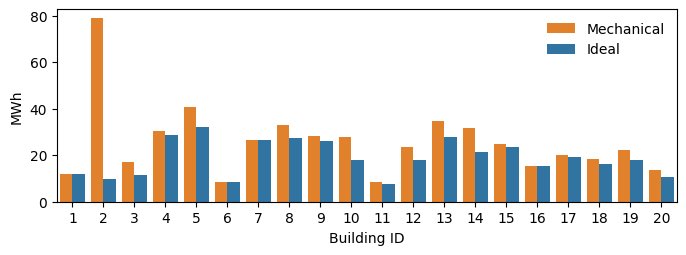

In [20]:
plot_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']<2)].groupby(['bldg_id', 'bldg_index', 'year', 'reference', 'reference_label'])[[
    'equipment_cooling_load', 'equipment_heating_load', 
    'ideal_cooling_load', 'ideal_heating_load', 
    'mechanical_cooling_load', 'mechanical_heating_load'
]].sum().reset_index()
plot_data.loc[plot_data['reference']==1, ('mechanical_cooling_load', 'mechanical_heating_load')] = (0.0, 0.0)
plot_data['cooling_load'] = plot_data[['equipment_cooling_load', 'ideal_cooling_load', 'mechanical_cooling_load']].sum(axis=1)/1000.0
plot_data['heating_load'] = plot_data[['equipment_heating_load', 'ideal_heating_load', 'mechanical_heating_load']].sum(axis=1)/1000.0
system_kwargs = {
    0: ('o', 'tab:orange'),
    1: ('x', 'tab:blue'),
    2: ('*', 'tab:green')
}
plot_data['color'] = plot_data['reference'].map(lambda x: system_kwargs[x][1])
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
reference_map = plot_data.groupby(['reference', 'reference_label']).size().reset_index().set_index('reference').to_dict('index')
palette = {v['reference_label']: system_kwargs[k][1] for k, v in reference_map.items()}
sns.barplot(data=plot_data, x='bldg_index', y='heating_load', hue='reference_label', palette=palette, ax=ax)
ax.set_xlabel('Building ID')
ax.set_ylabel('MWh')
ax.legend(title=None, framealpha=0.0)
plt.savefig(os.path.join(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, f'comparison_between_mechanical_and_ideal_load.pdf'), bbox_inches='tight', transparent=False)
plt.show()

## Comparison between ideal temperature and setpoint

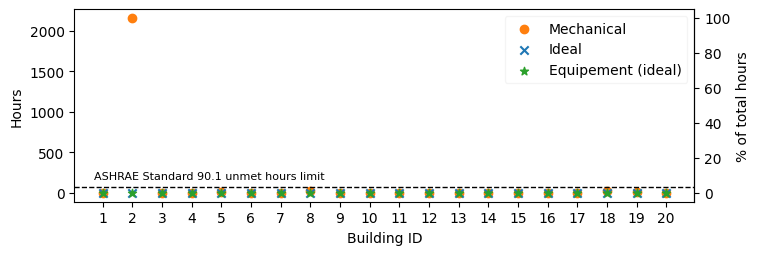

In [19]:
plot_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']<3)].copy()
max_time_index = plot_data['time_index'].max()
ashrae_unmet_limit = 300*max_time_index/8760
setpoint_data = plot_data[plot_data['reference']==0].copy()
plot_data = plot_data.drop(columns=['setpoint'])
plot_data = plot_data.merge(setpoint_data[['bldg_id', 'year', 'time_index', 'setpoint']], on=['bldg_id', 'year', 'time_index'])
plot_data['delta'] = plot_data['temperature'] - plot_data['setpoint']
throttling_range = 2 # C
plot_data['count'] = 0
plot_data.loc[plot_data['delta'].abs() > throttling_range*0.5, 'count'] = 1
plot_data = plot_data.groupby(['bldg_index', 'reference', 'reference_label'])[['count']].sum().reset_index()
reference_map = plot_data.groupby(['reference', 'reference_label']).size().reset_index().set_index('reference').to_dict('index')
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))

for r, rdata in plot_data.groupby('reference'):
    x = rdata['bldg_index'].astype(str).tolist()
    y = rdata['count'].tolist()
    ax.scatter(x, y, marker=system_kwargs[r][0], color=system_kwargs[r][1], label=reference_map[r]['reference_label'])

ax.axhline(ashrae_unmet_limit, color='black', linestyle='--', linewidth=1.0)
ax.text(-0.3, ashrae_unmet_limit + 100, 'ASHRAE Standard 90.1 unmet hours limit', fontsize=8)
ax.set_xlabel('Building ID')
ax.set_ylabel('Hours')
secax_y = ax.secondary_yaxis('right', functions=(lambda x: x*100.0/max_time_index, lambda x: x*max_time_index/100.0))
secax_y.set_ylabel('% of total hours')
ax.legend(framealpha=0.2)
plt.savefig(os.path.join(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, f'comparison_between_ideal_temperature_and_setpoint.pdf'), bbox_inches='tight', transparent=False)
plt.show()

## Partial temperature and setpoint difference distribution

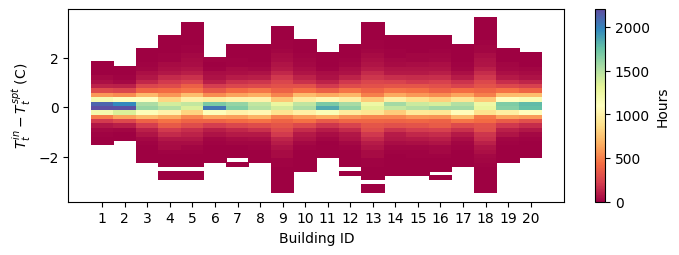

In [18]:
setpoint_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']==0)].copy()
plot_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']>3)].copy()
plot_data = plot_data.drop(columns=['setpoint'])
plot_data = plot_data.merge(setpoint_data[['bldg_id', 'time_index', 'setpoint']], on=['bldg_id', 'time_index'])
plot_data['delta'] = plot_data['temperature'] - plot_data['setpoint']
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
plot_data['bldg_index_str'] = plot_data['bldg_index'].astype(str)
sns.histplot(data=plot_data.sort_values('bldg_index'), x='bldg_index_str', y='delta', stat='count', bins=40, cmap='Spectral', ax=ax)
ax.set_xlabel('Building ID')
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label('Hours')
ax.set_ylabel(r'$T_t^{in} - T_t^{spt}$' + ' (C)')
plt.savefig(os.path.join(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, f'partial_temperature_and_setpoint_difference_distribution.pdf'), bbox_inches='tight', transparent=False)
plt.show()

## Partial and ideal temperature difference distribution

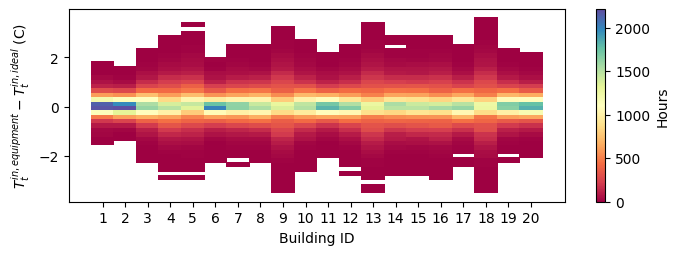

In [21]:
ideal_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']==2)].copy()
ideal_data = ideal_data.rename(columns={'temperature': 'ideal_temperature'})
plot_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']>3)].copy()
plot_data = plot_data.merge(ideal_data[['bldg_id', 'time_index', 'ideal_temperature']], on=['bldg_id', 'time_index'])
plot_data['delta'] = plot_data['temperature'] - plot_data['ideal_temperature']
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
plot_data['bldg_index_str'] = plot_data['bldg_index'].astype(str)
sns.histplot(data=plot_data.sort_values('bldg_index'), x='bldg_index_str', y='delta', stat='count', bins=40, cmap='Spectral', ax=ax)
ax.set_xlabel('Building ID')
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label('Hours')
ax.set_ylabel(r'$T_t^{in, equipment} - T_t^{in, ideal}$' + ' (C)')
plt.savefig(os.path.join(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, f'partial_and_ideal_temperature_difference_distribution.pdf'), bbox_inches='tight', transparent=False)
plt.show()

## Partial temperature change distribution

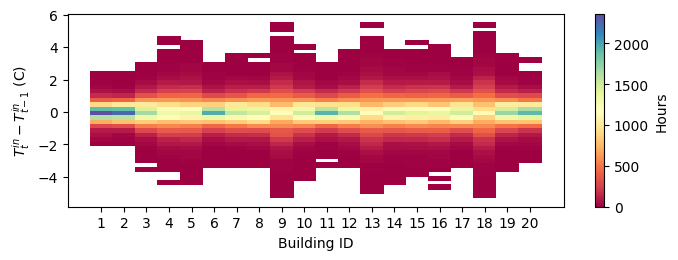

In [22]:
plot_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']>3)].copy()
shift_data = plot_data.sort_values('time_index').groupby(['bldg_id'])[['temperature']].shift(1)
shift_data = shift_data.rename(columns={'temperature': 'previous_temperature'})
plot_data = plot_data.merge(shift_data, left_index=True, right_index=True)
plot_data['delta'] = plot_data['temperature'] - plot_data['previous_temperature']
plot_data['bldg_index_str'] = plot_data['bldg_index'].astype(str)
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
sns.histplot(data=plot_data.sort_values('bldg_index'), x='bldg_index_str', y='delta', stat='count', bins=40, cmap='Spectral', ax=ax)
ax.set_xlabel('Building ID')
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label('Hours')
ax.set_ylabel(r'$T_t^{in} - T_{t-1}^{in}$' + ' (C)')
plt.savefig(os.path.join(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, f'partial_temperature_change_distribution.pdf'), bbox_inches='tight', transparent=False)
plt.show()

## Partial and ideal load difference distribution

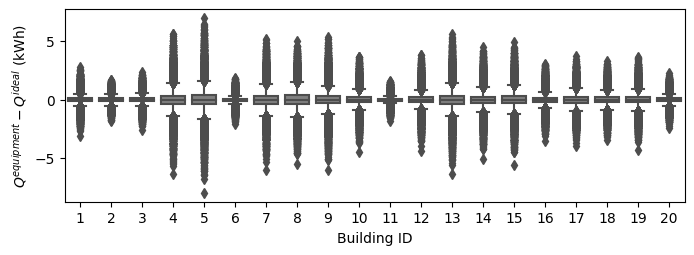

In [23]:
plot_data = data[(data['month']<=3) & (data['year']==data['year'].min()) & (data['reference']>1)].copy()
ideal_load_data = plot_data[plot_data['reference']==2].rename(columns={'equipment_heating_load': 'ideal_equipment_heating_load'}).copy()
plot_data = plot_data[plot_data['reference']>3].copy()
plot_data = plot_data.merge(ideal_load_data[['bldg_id', 'time_index', 'ideal_equipment_heating_load']], on=['bldg_id', 'time_index'], how='left')
plot_data['delta'] = plot_data['equipment_heating_load'] - plot_data['ideal_equipment_heating_load']
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
sns.boxplot(data=plot_data, x='bldg_index', y='delta', color='grey', ax=ax)
ax.set_xlabel('Building ID')
ax.set_ylabel(r'$Q^{equipment} - Q^{ideal}$' + ' (kWh)')
plt.savefig(os.path.join(FileHandler.JOURNAL_PAPER_FIGURES_DIRECTORY, f'partial_and_ideal_load_difference_distribution.pdf'), bbox_inches='tight', transparent=False)
plt.show()